# Ultilities

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import tqdm

def plot_distribution(array: np.ndarray, plot_name, unit_name, min, max) -> None:
    """
    Plots the distribution of a NumPy array using a histogram.

    Args:
        array (np.ndarray): Input array for which the distribution will be visualized.
    """
    # Plot the histogram
    if min is None:
        min = np.min(array)
    if max is None:
        max = np.max(array)
    array = array[(array >= min) & (array <= max)]
    plt.hist(array, color='lightgreen', ec='black', bins=1000)
    plt.xlabel(unit_name)
    plt.ylabel('Frequency')
    plt.title(plot_name)
    plt.show()

def relabel_data_based_on_threshold(smallest_threshold, input_df: pl.DataFrame, label_dict: dict):
    power_np = input_df.select("P").to_numpy()
    _max = power_np.max()
    _min = power_np.min()
    
    # Create a numpy array with dtype 'object' to hold string values
    label_np = np.zeros(len(power_np), dtype=object)
    no_device_idx = (power_np < smallest_threshold).reshape(len(power_np),)
    unlabeled_idx = (power_np >= smallest_threshold).reshape(len(power_np),)
    label_np[no_device_idx] = "no_device"
    label_np[unlabeled_idx] = "unlabeled"
    for key in label_dict.keys():
        min_threshold = label_dict[key][0] if label_dict[key][0] is not None else _min
        max_threshold = label_dict[key][1] if label_dict[key][1] is not None else _max
        relabeled_idx = np.array((power_np >= min_threshold) & (power_np <= max_threshold)).reshape(len(power_np),)
        label_np[relabeled_idx] = key
    input_df = input_df.with_columns(pl.Series(name="state_label", values=label_np))
    return input_df

def plot_data(input_df, which_plot: dict):
    plt.figure(figsize=(10, 6))
    if(which_plot["Irms"] == True):
        plt.plot(input_df['unix_ts'], input_df['Irms'], label='RMS Current (A)')
    if(which_plot["pf"] == True):
        plt.plot(input_df['unix_ts'], input_df['I'], label='Power factor')
    if(which_plot["P"] == True):
        plt.plot(input_df['unix_ts'], input_df['P'], label='Power (Watt)')
    if(which_plot["Q"] == True):
        plt.plot(input_df['unix_ts'], input_df['Q'], label='Reactive Power Q (VAR)')
    if(which_plot["S"] == True):
        plt.plot(input_df['unix_ts'], input_df['S'], label='Apparent Power S (...)')
    plt.xlabel('Unix Timestamp')
    plt.ylabel('Values')
    plt.title(f'{which_plot["name"]}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def find_on_off_time(smallest_threshold, input_df: pl.DataFrame):
    power_np = input_df.select("P").to_numpy()
    # Create a numpy array with dtype 'object' to hold string values
    label_np = np.zeros(len(power_np), dtype=object)
    no_device_idx = (power_np < smallest_threshold).reshape(len(power_np),)
    unlabeled_idx = (power_np >= smallest_threshold).reshape(len(power_np),)
    label_np[no_device_idx] = "off"
    label_np[unlabeled_idx] = "on"
    input_df = input_df.with_columns(pl.Series(name="on_off_label", values=label_np))
    return input_df
    
def get_running_segments(input_df: pl.DataFrame, min_length, smallest_threshold):
    on_times, off_times = [], []
    device_running_dfs = []
    new_labeled_dataset = find_on_off_time(smallest_threshold=smallest_threshold, 
                                           input_df=input_df)
    starting_np = new_labeled_dataset[0].to_numpy()[0]
    previous_time = starting_np[1]
    previous_state = starting_np[len(starting_np) - 1]
    
    # Initialize tqdm progress bar for labeling
    progress_bar_labeling = tqdm.tqdm(total=len(new_labeled_dataset), desc="Labeling ON/OFF")
    for rows in new_labeled_dataset.iter_rows():
        current_time = rows[1]
        current_label = rows[len(rows) - 1]
        if previous_state == "off" and current_label == "on":
            on_times.append(previous_time)
        elif previous_state == "on" and current_label == "off":
            off_times.append(current_time)
        previous_state = current_label
        previous_time = current_time
        # Update tqdm progress bar for labeling
        progress_bar_labeling.update(1)
    progress_bar_labeling.close()
    
    # Initialize tqdm progress bar for segments
    progress_bar_segments = tqdm.tqdm(total=np.min([len(on_times), len(off_times)]), desc="Processing segments")
    
    for i in range(np.min([len(on_times), len(off_times)])):
        running_df = input_df.filter((pl.col("unix_ts") >= on_times[i]) & (pl.col("unix_ts") <= off_times[i]))
        if (len(running_df) > min_length):
            device_running_dfs.append(running_df) 
        # Update tqdm progress bar for segments
        progress_bar_segments.update(1)
    progress_bar_segments.close()
    
    return device_running_dfs

def export_to_files(output_path, device_name, dfs):
    progress_bar = tqdm.tqdm(total=len(dfs), desc="Exporting to file")
    for i in range(len(dfs)):
        clothes_dryer_df = dfs[i]
        clothes_dryer_df.to_pandas().to_excel(os.path.join(output_path, f"{device_name}_{i}.xlsx"))
        progress_bar.update(1)
    progress_bar.close()

# Clothes dryer

## Distribution plotting

In [4]:
house1_clothes_dryer = pl.read_csv("/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/raw/house1_clothes_dryer.csv")
print(len(house1_clothes_dryer))
house1_clothes_dryer.head()

6068210


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,f64,f64,f64,str
0,1457251200,0.0,0.0,0.0,0.0,5.0,"""clothes_dryer"""
1,1457251201,0.0,0.0,0.0,0.0,5.0,"""clothes_dryer"""
2,1457251202,0.0,0.0,0.0,0.0,5.0,"""clothes_dryer"""
3,1457251203,0.0,0.0,0.0,0.0,5.0,"""clothes_dryer"""
4,1457251204,0.0,0.0,0.0,0.0,5.0,"""clothes_dryer"""


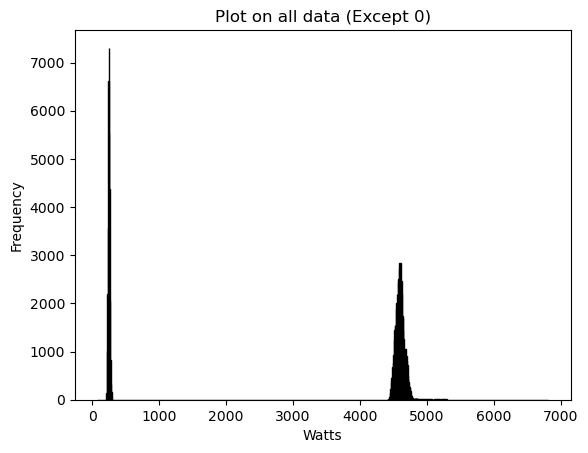

In [6]:
plot_distribution(array=house1_clothes_dryer.select("P").to_numpy(), 
                  min=20,
                  max=None,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

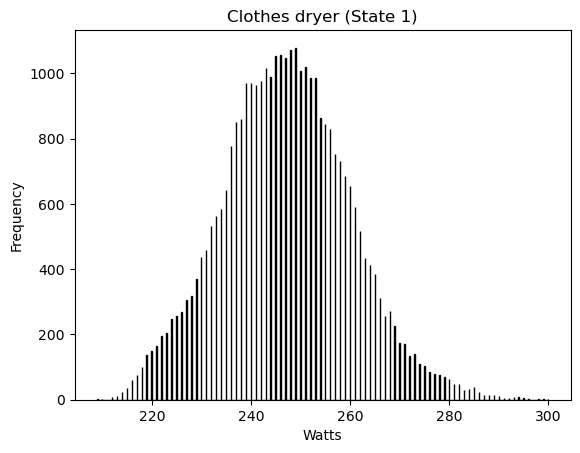

In [7]:
plot_distribution(array=house1_clothes_dryer.select("P").to_numpy(), 
                  min=100, 
                  max=300,
                  plot_name="Clothes dryer (State 1)", 
                  unit_name="Watts")

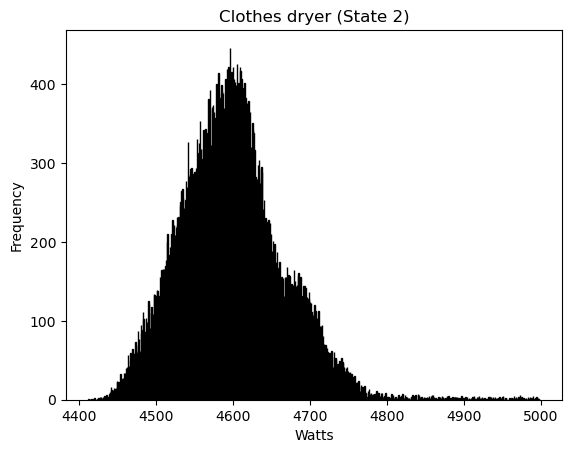

In [8]:
plot_distribution(array=house1_clothes_dryer.select("P").to_numpy(), 
                  min=4200, 
                  max=5000,
                  plot_name="Clothes dryer (State 2)", 
                  unit_name="Watts")

__This device have two states__
- No device running: P < 20 (W)
- State 1: From 200 < P < 300 (W)
- State 2: From P > 4400 (W)

## Relabeling data

In [10]:
clothes_dryers_dfs = get_running_segments(input_df=house1_clothes_dryer, min_length=10, smallest_threshold=100)

Processing segments: 100%|██████████| 45/45 [00:03<00:00, 13.58it/s]


In [11]:
len(clothes_dryers_dfs)

44

In [14]:
clothes_dryers_dfs[0].head()

,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,f64,f64,f64,str
522823,1457829611,0.0,0.0,0.0,0.0,5.0,"""clothes_dryer"""
522824,1457829612,45.7,0.994812,5369.0,393.0,5397.0,"""clothes_dryer"""
522825,1457829613,44.3,0.995027,5202.0,399.0,5228.0,"""clothes_dryer"""
522826,1457829614,43.3,0.994916,5088.0,398.0,5114.0,"""clothes_dryer"""
522827,1457829615,42.8,0.994666,5035.0,394.0,5062.0,"""clothes_dryer"""


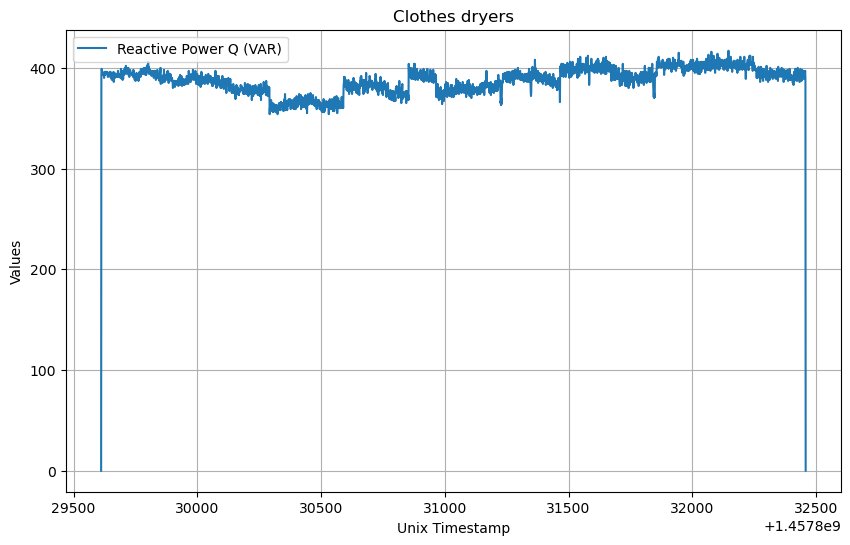

In [17]:
plot_data(clothes_dryers_dfs[4], {
        "name": "Clothes dryers",
        "Irms": False,
        "P": False,
        "pf": False,
        "Q": True,
        "S": False
    })

In [67]:
output_path = "/home/mrcong/Code/mylab-nilm-files/data_adapter/data/RAE_dataset/transform_data/running_segments/clothes_dryer"
for i in range(len(clothes_dryers_dfs)):
    clothes_dryer_df = clothes_dryers_dfs[i]
    clothes_dryer_df.to_pandas().to_excel(os.path.join(output_path, f"clothes_dryer_{i}.xlsx"))

# Frigde

In [3]:
h1_fridge = pl.read_csv("../../data/RAE_dataset/transform_data/raw/house1_kitchen_fridge.csv")
print(len(h1_fridge))
h1_fridge.head()

6068210


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,i64,i64,i64,str
0,1457251200,0.0,0.0,0,5,5,"""kitchen_fridge…"
1,1457251201,0.0,0.0,0,5,5,"""kitchen_fridge…"
2,1457251202,0.0,0.0,0,5,5,"""kitchen_fridge…"
3,1457251203,0.0,0.0,0,4,5,"""kitchen_fridge…"
4,1457251204,0.0,0.0,0,5,5,"""kitchen_fridge…"


## Distribution plotting

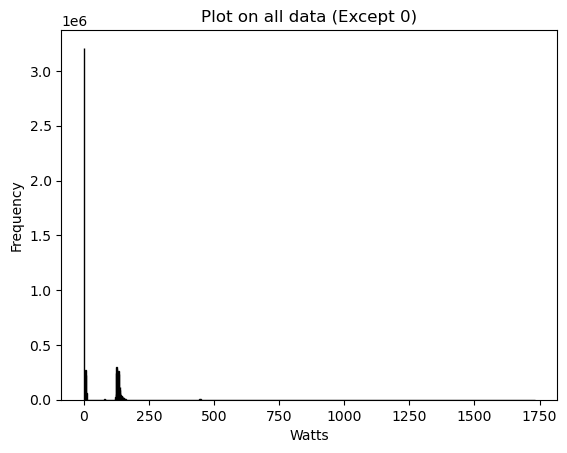

In [4]:
plot_distribution(array=h1_fridge.select("P").to_numpy(), 
                  min=None, 
                  max=None,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

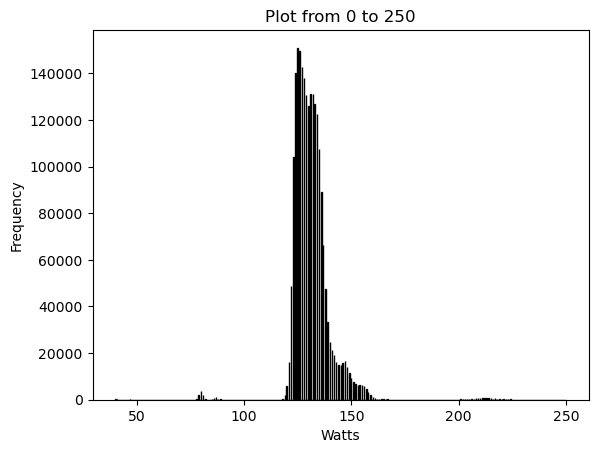

In [5]:
plot_distribution(array=h1_fridge.select("P").to_numpy(), 
                  min=40, 
                  max=250,
                  plot_name="Plot from 0 to 250", 
                  unit_name="Watts")

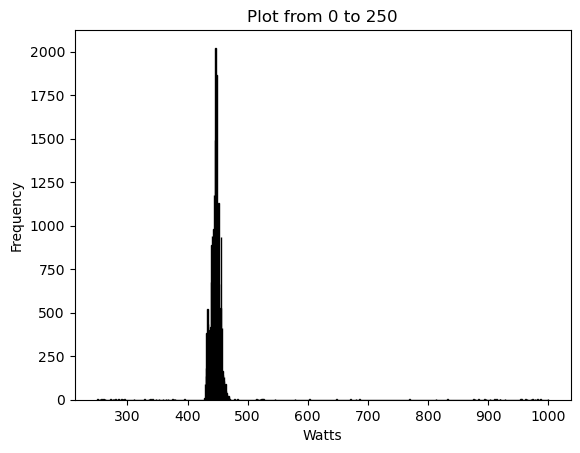

In [6]:
plot_distribution(array=h1_fridge.select("P").to_numpy(), 
                  min=250, 
                  max=1000,
                  plot_name="Plot from 0 to 250", 
                  unit_name="Watts")

=> Lower than 20W -> not working

## Get running segments data

In [4]:
h1_fridge_running_dfs = get_running_segments(input_df=h1_fridge, min_length=10, smallest_threshold=40)

Processing segments: 100%|█████████▉| 3940/3941 [05:01<00:00, 13.07it/s]


In [ ]:
for i in range(0, 2):
    test_df = h1_fridge_running_dfs[i]
    plot_data(input_df=test_df, which_plot={
        "name": "Fridge data",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [13]:
export_to_files(output_path="../../data/RAE_dataset/transform_data/kitchen_fridge", 
                device_name="fridge", 
                dfs=h1_fridge_running_dfs)

# Kitchen oven

In [7]:
h1_oven = pl.read_csv("../../data/RAE_dataset/transform_data/raw/house1_kitchen_oven.csv")
print(len(h1_oven))
h1_oven.head()

6068210


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,f64,f64,f64,str
0,1457251200,0.0,0.166667,1.0,0.0,6.0,"""kitchen_oven"""
1,1457251201,0.0,0.166667,1.0,0.0,6.0,"""kitchen_oven"""
2,1457251202,0.0,0.166667,1.0,0.0,6.0,"""kitchen_oven"""
3,1457251203,0.0,0.166667,1.0,0.0,6.0,"""kitchen_oven"""
4,1457251204,0.0,0.166667,1.0,0.0,6.0,"""kitchen_oven"""


## Distribution plot

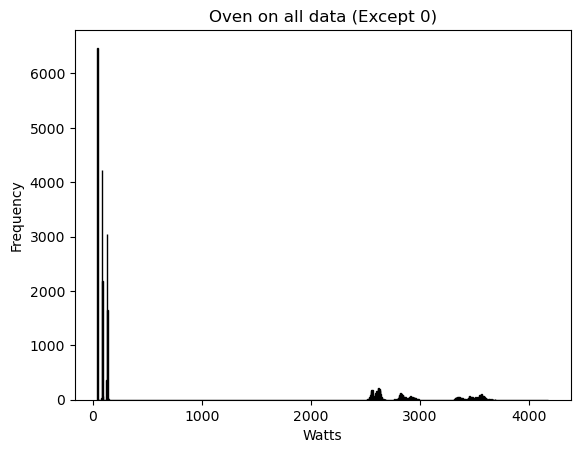

In [11]:
plot_distribution(array=h1_oven.select("P").to_numpy(), 
                  min=20, 
                  max=None,
                  plot_name="Oven on all data (Except 0)", 
                  unit_name="Watts")

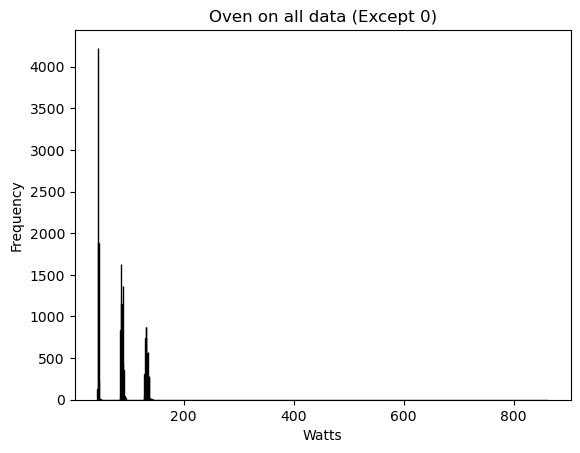

In [12]:
plot_distribution(array=h1_oven.select("P").to_numpy(), 
                  min=20, 
                  max=1000,
                  plot_name="Oven on all data (Except 0)", 
                  unit_name="Watts")

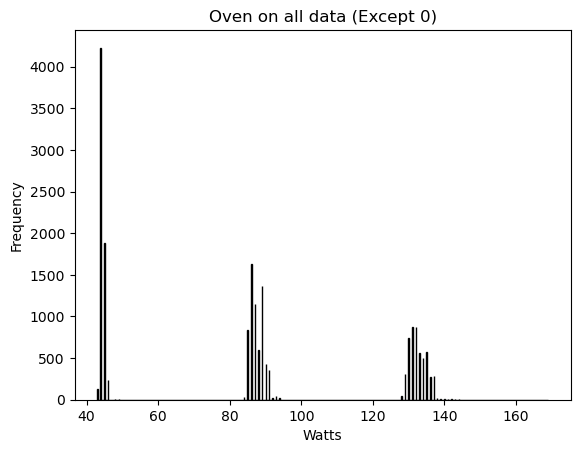

In [15]:
plot_distribution(array=h1_oven.select("P").to_numpy(), 
                  min=20, 
                  max=200,
                  plot_name="Oven on all data (Except 0)", 
                  unit_name="Watts")

__=> Min threshold = 40__

## Getting running segments data

In [29]:
h1_oven_running_dfs = get_running_segments(input_df=h1_oven, min_length=10, smallest_threshold=40)
print(f"Overall dataframe: {len(h1_oven_running_dfs)}")

Processing segments: 100%|██████████| 8/8 [00:00<00:00, 15.50it/s]

Overall dataframe: 6


In [ ]:
for i in range(len(h1_oven_running_dfs)):
    test_df = h1_oven_running_dfs[i]
    plot_data(input_df=test_df, which_plot={
        "name": "Oven data",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [32]:
export_to_files(output_path="../../data/RAE_dataset/transform_data/running_segments/oven", 
                device_name="oven", 
                dfs=h1_oven_running_dfs)

Exporting to file: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


# Lights and plugs 3

In [33]:
h2_lp3 = pl.read_csv("../../data/RAE_dataset/transform_data/raw/house2_lights_and_plugs_3.csv")
print(len(h2_lp3))
h2_lp3.head()

4980389


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,i64,i64,i64,str
0,1505286000,0.0,0.0,0,0,0,"""lights_and_plu…"
1,1505286001,0.0,0.0,0,0,2,"""lights_and_plu…"
2,1505286002,0.0,0.0,0,0,2,"""lights_and_plu…"
3,1505286003,0.0,0.0,0,0,2,"""lights_and_plu…"
4,1505286004,0.0,0.0,0,0,2,"""lights_and_plu…"


## Distribution plot

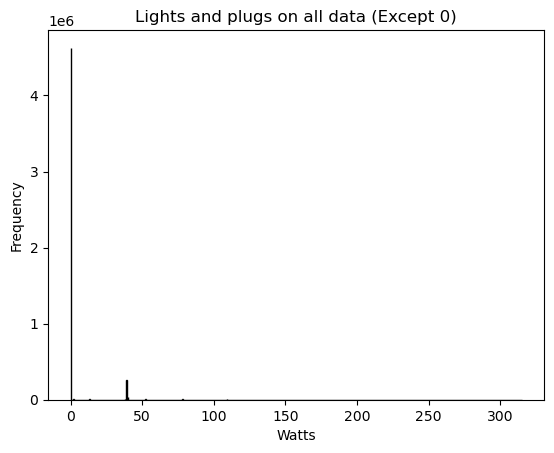

In [34]:
plot_distribution(array=h2_lp3.select("P").to_numpy(), 
                  min=None, 
                  max=None,
                  plot_name="Lights and plugs on all data (Except 0)", 
                  unit_name="Watts")

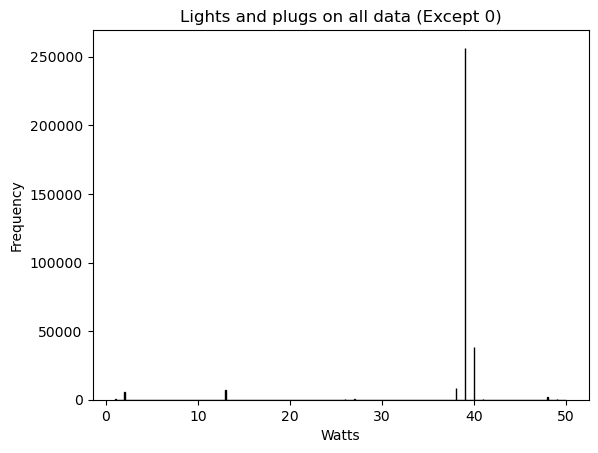

In [36]:
plot_distribution(array=h2_lp3.select("P").to_numpy(), 
                  min=1, 
                  max=50,
                  plot_name="Lights and plugs on all data (Except 0)", 
                  unit_name="Watts")

## Getting running segments

In [37]:
h2_lp3_running_dfs = get_running_segments(input_df=h2_lp3, min_length=10, smallest_threshold=20)
print(f"Overall dataframe: {len(h2_lp3_running_dfs)}")

Processing segments: 100%|██████████| 86/86 [00:05<00:00, 15.57it/s]

Overall dataframe: 72


In [ ]:
for i in range(3):
    test_df = h2_lp3_running_dfs[i]
    plot_data(input_df=test_df, which_plot={
        "name": "LP3 data",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [42]:
export_to_files(output_path="../../data/RAE_dataset/transform_data/running_segments/lp3", 
                device_name="lights_plugs_3", 
                dfs=h2_lp3_running_dfs)

Exporting to file: 100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


# Lights and plugs 16

In [3]:
h2_lp16 = pl.read_csv("../../data/RAE_dataset/transform_data/raw/house2_lights_and_plugs_16.csv")
print(len(h2_lp16))
h2_lp16.head()

4980389


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,i64,i64,i64,str
0,1505286000,0.0,0.0,0,0,2,"""lights_and_plu…"
1,1505286001,0.0,0.0,0,0,2,"""lights_and_plu…"
2,1505286002,0.0,0.0,0,0,2,"""lights_and_plu…"
3,1505286003,0.0,0.0,0,0,2,"""lights_and_plu…"
4,1505286004,0.0,0.0,0,0,2,"""lights_and_plu…"


## Distribution plot

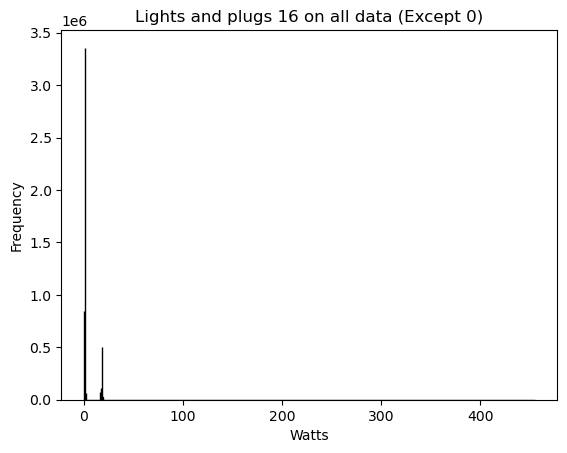

In [4]:
plot_distribution(array=h2_lp16.select("P").to_numpy(), 
                  min=None, 
                  max=None,
                  plot_name="Lights and plugs 16 on all data (Except 0)", 
                  unit_name="Watts")

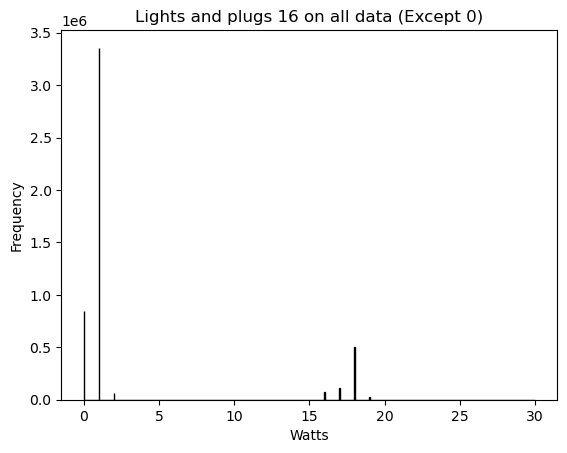

In [5]:
plot_distribution(array=h2_lp16.select("P").to_numpy(), 
                  min=0, 
                  max=100,
                  plot_name="Lights and plugs 16 on all data (Except 0)", 
                  unit_name="Watts")

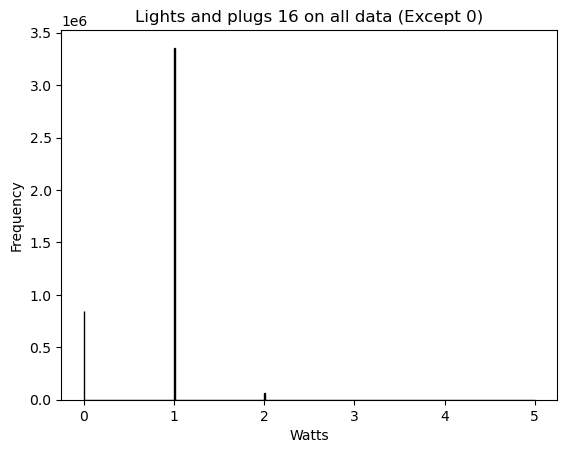

In [6]:
plot_distribution(array=h2_lp16.select("P").to_numpy(), 
                  min=0, 
                  max=5,
                  plot_name="Lights and plugs 16 on all data (Except 0)", 
                  unit_name="Watts")

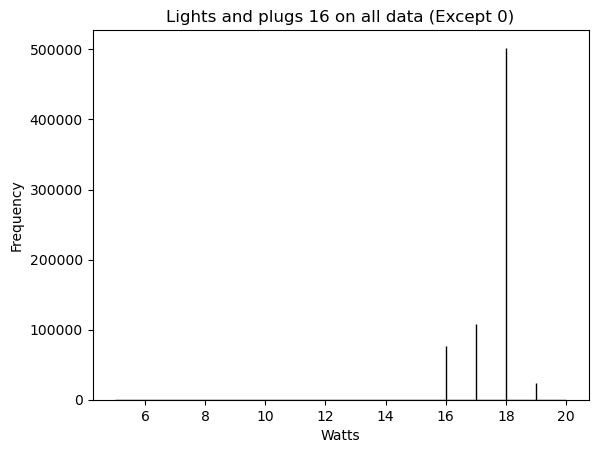

In [7]:
plot_distribution(array=h2_lp16.select("P").to_numpy(), 
                  min=5, 
                  max=20,
                  plot_name="Lights and plugs 16 on all data (Except 0)", 
                  unit_name="Watts")

=> Min threshold = 10 W

## Getting running segments

In [9]:
h2_lp16_running_dfs = get_running_segments(input_df=h2_lp16, min_length=10, smallest_threshold=10)
print(f"Overall dataframe: {len(h2_lp16_running_dfs)}")

Processing segments: 100%|██████████| 319/319 [00:20<00:00, 15.79it/s]

Overall dataframe: 300


In [ ]:
for i in range(20, 25):
    plot_data(input_df=h2_lp16_running_dfs[i], which_plot={
        "name": "LP16 data",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [17]:
export_to_files(output_path="../../data/RAE_dataset/transform_data/running_segments/lp16", 
                device_name="lights_and_plugs_16", 
                dfs=h2_lp16_running_dfs)

Exporting to file: 100%|██████████| 300/300 [01:07<00:00,  4.44it/s]


# Lights and plugs 20

In [13]:
h2_lp20 = pl.read_csv("../../data/RAE_dataset/transform_data/raw/house2_lights_and_plugs_20.csv")
print(len(h2_lp20))
h2_lp20.head()

4980389


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,i64,i64,i64,str
0,1505286000,0.0,0.0,0,0,0,"""lights_and_plu…"
1,1505286001,0.0,0.0,0,0,2,"""lights_and_plu…"
2,1505286002,0.0,0.0,0,0,2,"""lights_and_plu…"
3,1505286003,0.0,0.0,0,0,0,"""lights_and_plu…"
4,1505286004,0.0,0.0,0,0,0,"""lights_and_plu…"


## Distribution plot

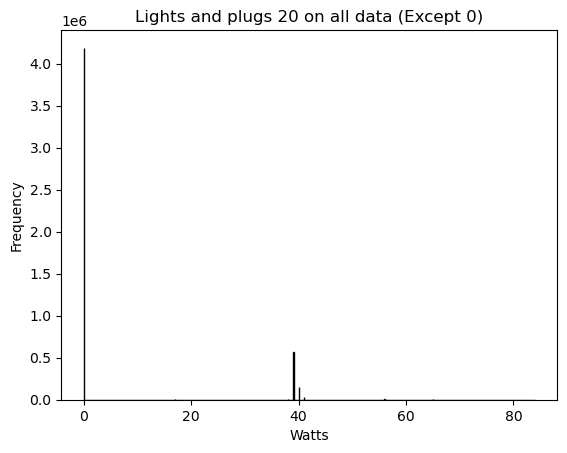

In [14]:
plot_distribution(array=h2_lp20.select("P").to_numpy(), 
                  min=None, 
                  max=None,
                  plot_name="Lights and plugs 20 on all data (Except 0)", 
                  unit_name="Watts")

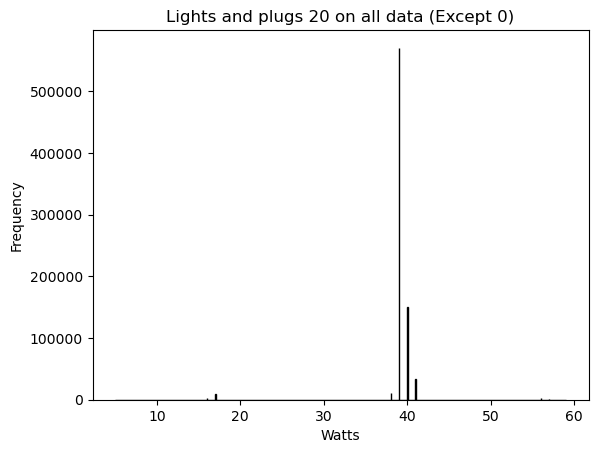

In [15]:
plot_distribution(array=h2_lp20.select("P").to_numpy(), 
                  min=5, 
                  max=60,
                  plot_name="Lights and plugs 20 on all data (Except 0)", 
                  unit_name="Watts")

=> Min threshold = 30

## Getting running segments

In [16]:
h2_lp20_running_dfs = get_running_segments(input_df=h2_lp20, min_length=10, smallest_threshold=30)
print(f"Overall dataframe: {len(h2_lp20_running_dfs)}")

Processing segments: 100%|██████████| 388/388 [00:24<00:00, 15.88it/s]

Overall dataframe: 372


In [ ]:
for i in range(20, 25):
    plot_data(input_df=h2_lp20_running_dfs[i], which_plot={
        "name": "LP16 data",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [19]:
export_to_files(output_path="../../data/RAE_dataset/transform_data/running_segments/lp20", 
                device_name="lights_and_plugs_20", 
                dfs=h2_lp20_running_dfs)

Exporting to file: 100%|██████████| 372/372 [01:13<00:00,  5.07it/s]
